In [ ]:
!pip install kaggle

In [ ]:
kaggle.api.authenticate()

NameError: name 'kaggle' is not defined

In [ ]:
import kaggle


OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download bhaveshmittal/melanoma-cancer-dataset

 93% 74.0M/79.4M [00:02<00:00, 40.6MB/s]
100% 79.4M/79.4M [00:02<00:00, 29.9MB/s]


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!unzip melanoma-cancer-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import keras


In [ ]:
train_path = "/content/train"

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.


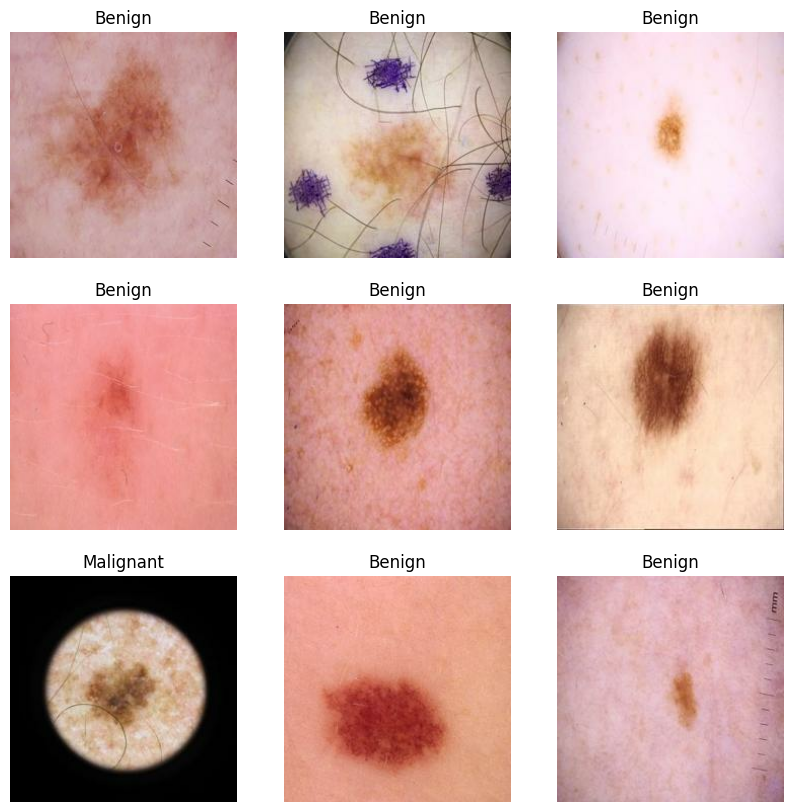

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
augmentation_layers = [
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.3)
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

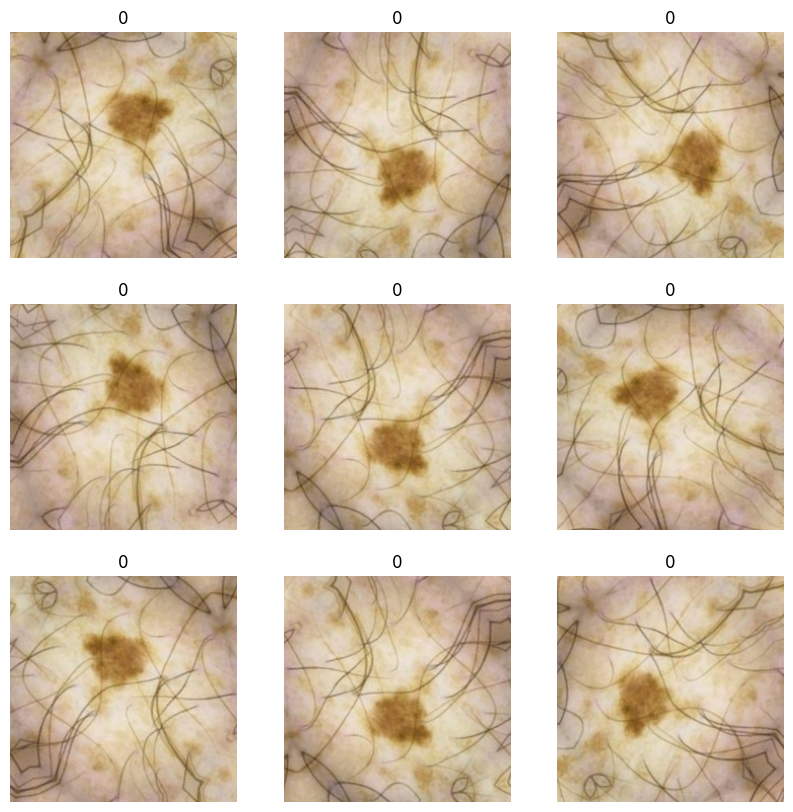

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
scale_layer = keras.layers.Rescaling(scale = 1/127.5, offset = -1)
x = scale_layer(inputs)
x = base_model(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable = True)

83683744/83683744 [==============================] - 3s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = [keras.metrics.BinaryAccuracy()]
)

In [ ]:
epochs = 3
model.fit(train_ds, epochs = epochs, validation_data = val_ds)

Epoch 1/3
149/149 [==============================] - 107s 641ms/step - loss: 0.4638 - binary_accuracy: 0.7519 - val_loss: 0.3781 - val_binary_accuracy: 0.8295
Epoch 2/3
149/149 [==============================] - 91s 609ms/step - loss: 0.3871 - binary_accuracy: 0.8068 - val_loss: 0.3469 - val_binary_accuracy: 0.8337
Epoch 3/3
149/149 [==============================] - 91s 612ms/step - loss: 0.3673 - binary_accuracy: 0.8197 - val_loss: 0.3386 - val_binary_accuracy: 0.8518


In [ ]:
model.load_weights("xception.weights.h5")
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1

model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 7, 7, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
model.save_weights("xception.weights.h5")